In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse
import requests, re, time
import pandas_datareader
import pickle
import math

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns 
import matplotlib.lines as lines


import statsmodels.api as sm
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from selenium import webdriver
import time

import geopy.distance

In [2]:
Apartments = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 4.pkl','rb'))

In [3]:
data_sorted = Apartments.sort_values(['Address','Date_sold'])

# Problem with some pgaes being scraped more than once - deleting duplicate rows:
data_sorted = data_sorted.sort_values(['Date_sold'])
data_sorted['Price_mio'] = data_sorted['Price']/10**6
data_sorted['log_Price_sq_m_1000'] = np.log(data_sorted['Price_sq_m_1000'])

data_sorted['Cityring'] = 0
for i in range(0,len(data_sorted)):
    if Apartments['Closest Metro'][i]['Cityring'] == 1:
        data_sorted['Cityring'][i] = 1

data_sorted = data_sorted.reset_index()

# Sorting and creating daily averages and moving average for graphing:
dailyavg = data_sorted.groupby('Date_sold').agg(
    Dailyavg_mio = ('Price_mio','mean'),
    Dailyavg_sq = ('Price_sq_m_1000','mean')
)
dailyavg['Day'] = dailyavg.index.to_list()
dailyavg['MovAvg'] = dailyavg['Dailyavg_sq'].rolling(window=500,center=True).mean()
data_sorted['Closest Metro dist'] = [i['Distance'] for i in data_sorted['Closest Metro']]

In [4]:
K = data_sorted[(data_sorted['Area'] == 'K')]
N = data_sorted[(data_sorted['Area'] == 'N')]
NV = data_sorted[(data_sorted['Area'] == 'NV')]
V = data_sorted[(data_sorted['Area'] == 'V')]

dailyavg['MovAvg'] = dailyavg['Dailyavg_sq'].rolling(window=500,center=True).mean()

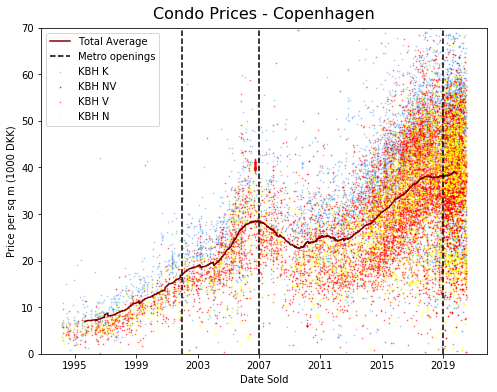

In [178]:
fig, ax1 = plt.subplots(figsize=(8,6), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

plt.title('Condo Prices - Copenhagen',**title_font)

#Plotting wheat price:
goldman_blue = '#64a8f0'   
ax1.scatter(K['Date_sold'],K['Price_sq_m_1000'], label='KBH K', c=goldman_blue,s=0.5,alpha=0.5)
ax1.scatter(NV['Date_sold'],NV['Price_sq_m_1000'], label='KBH NV', c='black',s=0.5,alpha=0.5)
ax1.scatter(V['Date_sold'],V['Price_sq_m_1000'], label='KBH V', c='red',s=0.5,alpha=0.5)
ax1.scatter(N['Date_sold'],N['Price_sq_m_1000'], label='KBH N', c='yellow',s=0.5,alpha=0.5)

ax1.plot(dailyavg['Day'],dailyavg['MovAvg'],c='maroon',label='Total Average')

plt.axvline('2002',linestyle='--',c='black', label = 'Metro openings')
plt.axvline('2007',linestyle='--',c='black')
plt.axvline('2019',linestyle='--',c='black')




plt.tick_params()
ax1.set_ylim(0,70)
plt.xlabel('Date Sold')
plt.ylabel('Price per sq m (1000 DKK)')
plt.legend(loc='upper left')


# Only Cityring: With q25-q75 band

In [5]:
data_sorted['Month'] = data_sorted['Date_sold'].dt.to_period('M')
Cityring = data_sorted[(data_sorted['Cityring'] == 1)]
Close = Cityring[(Cityring['Closest Metro dist'] < 0.5)]
Far = Cityring[(Cityring['Closest Metro dist'] > 0.5)]
Far = Far[(Far['Closest Metro dist'] < 100)]
Close.reset_index(inplace=True)
Far.reset_index(inplace=True)

In [6]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

Monthly_Close = Close.groupby('Month').agg(
    Month_mean = ('log_Price_sq_m_1000','mean'),
    Month_std = ('log_Price_sq_m_1000','std'),
    Month_lowerbound = ('log_Price_sq_m_1000',q25),
    Month_upperbound = ('log_Price_sq_m_1000',q75)


)
Monthly_Far = Far.groupby('Month').agg(
    Month_mean = ('log_Price_sq_m_1000','mean'),
    Month_std = ('log_Price_sq_m_1000','std'),
    Month_lowerbound = ('log_Price_sq_m_1000',q25),
    Month_upperbound = ('log_Price_sq_m_1000',q75)
)


Monthly_Close['MovAvg'] = Monthly_Close['Month_mean'].rolling(window=100,center=True).mean()
Monthly_Far['MovAvg'] = Monthly_Far['Month_mean'].rolling(window=100,center=True).mean()
Monthly_Close['Month'] = Monthly_Close.index.to_list()
Monthly_Close['Month'] = [i.to_timestamp() for i in Monthly_Close['Month']]
Monthly_Far['Month'] = Monthly_Far.index.to_list()
Monthly_Far['Month'] = [i.to_timestamp() for i in Monthly_Far['Month']]
Monthly_Close = Monthly_Close[Monthly_Close['Month_std'].notna()]
Monthly_Far = Monthly_Far[Monthly_Far['Month_std'].notna()]

In [7]:
Dailyavg_close = Close.groupby('Date_sold').agg(
    Dailyavg_sq = ('log_Price_sq_m_1000','mean')
)
Dailyavg_far = Far.groupby('Date_sold').agg(
   Dailyavg_sq = ('log_Price_sq_m_1000','mean')
)

Dailyavg_close['MovAvg'] = Dailyavg_close['Dailyavg_sq'].rolling(window=100,center=True).mean()
Dailyavg_far['MovAvg'] = Dailyavg_far['Dailyavg_sq'].rolling(window=100,center=True).mean()
Dailyavg_close['Day'] = Dailyavg_close.index.to_list()
Dailyavg_far['Day'] = Dailyavg_far.index.to_list()

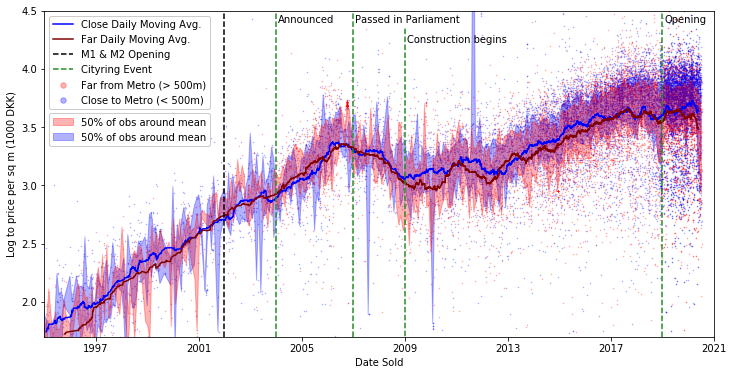

In [20]:
fig, ax1 = plt.subplots(figsize=(12,6), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

#plt.title('Average price per square meters on a given day (Inner Copenhagen)',**title_font)

# Plotting observations
ax1.scatter(Far['Date_sold'],Far['log_Price_sq_m_1000'],label='Far from Metro (> 500m)', c='red',s=0.3,alpha=0.3)
ax1.scatter(Close['Date_sold'],Close['log_Price_sq_m_1000'],label='Close to Metro (< 500m)', c='blue',s=0.3,alpha=0.3)


# MovAvg
ax1.plot(Dailyavg_close['Day'],Dailyavg_close['MovAvg'],c='blue',label='Close Daily Moving Avg.')
ax1.plot(Dailyavg_far['Day'],Dailyavg_far['MovAvg'],c='maroon',label='Far Daily Moving Avg.')

# Confidence interval
ax1.fill_between(Monthly_Close['Month'], (Monthly_Close['Month_lowerbound']), (Monthly_Close['Month_upperbound']), color='b', alpha=.3)

ax1.fill_between(Monthly_Far['Month'], (Monthly_Far['Month_lowerbound']), (Monthly_Far['Month_upperbound']), color='r', alpha=.3)

plt.axvline('2002',linestyle='--',c='black', label='M1 & M2 Opening')
plt.axvline('2019',linestyle='--',c='forestgreen')
plt.axvline('2004',linestyle='--',c='forestgreen')
plt.axvline('2007',linestyle='--',c='forestgreen',label = 'Cityring Event')
ax1.add_artist(lines.Line2D('2009', [0,4.35], linestyle='--',c='forestgreen'))


t = ax1.text('2019-02-01', 4.4, 'Opening')
t = ax1.text('2007-02-01', 4.4, 'Passed in Parliament')
t = ax1.text('2004-02-01', 4.4, 'Announced')
t = ax1.text('2009-02-01', 4.23, 'Construction begins')



plt.tick_params()
ax1.set_ylim(1.7,4.5)
ax1.set_xlim('1995','2021')
plt.xlabel('Date Sold')
plt.ylabel('Log to price per sq m (1000 DKK)')

blue = mpatches.Patch(color='b', label=f'50% of obs around mean',alpha=0.3)
red = mpatches.Patch(color='r', label=f'50% of obs around mean',alpha=0.3)


# Legends:
legend1 = plt.legend(handles=[red, blue], loc='upper left', frameon=True, framealpha=1, bbox_to_anchor=(0,0.7))
plt.legend(loc='upper left',frameon=True,markerscale=10,framealpha=1)
ax1.add_artist(legend1)
